<a href="https://colab.research.google.com/github/dkalenov/ML-Stock-Crypto-Trading/blob/3_reinforcement/PPO_Sine_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resources

PPO Code adapted from https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)

### ENVIRONMENT

Let's generate data on which the PPO (Proximal Policy Optimization) reinforcement learning algorithm will be trained.

After creating a DataFrame with a sinusoidal time series and percentage price change, this DataFrame can be used to train a PPO algorithm based on time data. This approach allows us to examine how the PPO algorithm copes with trading on an artificial time series and evaluate its performance.

In [1]:
import numpy as np
import pandas as pd

# Create timesteps
time = np.arange(0, 50, 0.1)

# Assign amplitude and normalise above 0
amplitude = np.sin(time)
amplitude = amplitude + 1
max_amp = max(amplitude)
amplitude = amplitude / max_amp

# Construct DataFrame
df = pd.DataFrame(amplitude)
df.columns = ["Close"]
df["Close_Rt"] = df["Close"].pct_change()
df = df.replace(np.inf, np.nan)
df = df.dropna()
df = df.reset_index(drop=True)

# Show DataFrame and Values
print(f"length : {len(df)}")
print("Min Close: ", df["Close"].min())
print("Max Close: ", df["Close"].max())
df.head()

length : 499
Min Close:  4.896739968063352e-06
Max Close:  1.0


,Close,Close_Rt
0,0.549918,0.099833
1,0.599337,0.089864
2,0.647762,0.080799
3,0.694711,0.072479
4,0.739715,0.064780


<Axes: >

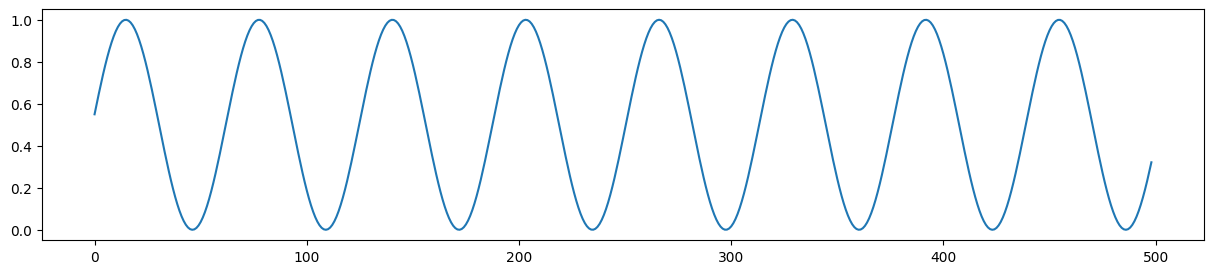

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
df["Close"].plot()

In [4]:
import gym
from gym import spaces # use Gym 0.24.0 from pip install
import numpy as np
import random
import torch


# Initialise variables
MAX_INT = 2147483647  # Maximum integer value
MAX_OPEN_POSITIONS = 1  # Maximum number of open positions allowed
INITIAL_ACCOUNT_BALANCE = 1000  # Initial account balance
PERCENT_CAPITAL = 0.1  # Percentage of capital to be invested per trade
TRADING_COSTS_RATE = 0.001  # Trading costs rate (e.g., commission or fees)
KILL_THRESH = 0.4  # Threshold for balance preservation (e.g., percentage of initial balance)

# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        # Generic variables
        self.df = df

        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.last_profit = 0

        # Position variables
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.closed_positions = 0
        self.incorrect_position_calls = 0
        self.num_trades = 0
        self.held_for_period = 0

        # Current Step
        self.current_step = 0
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(3)

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(8, ), dtype=np.float32) # shape=(8, ) equals obs amount in  _next_observation(self)

    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        if self.num_trades:
            reward += self.realized_profit / self.num_trades
            reward += self.unrealized_profit / self.num_trades * 0.3
            reward += 1 if self.last_profit > 0 else 0
        reward -= 1 if self.incorrect_position_calls > 0 else 0
        if reward <= 0:
            reward -= 2
        return reward

    # Structure sign observation data
    def _next_observation(self):
        close_item = self.df.loc[self.current_step, "Close"].item()
        close_rt_item = self.df.loc[self.current_step, "Close_Rt"].item()
        close_T1_item = self.df.loc[self.current_step - 1, "Close_Rt"].item()
        close_T2_item = self.df.loc[self.current_step - 2, "Close_Rt"].item()
        close_T3_item = self.df.loc[self.current_step - 3, "Close_Rt"].item()
        close_T4_item = self.df.loc[self.current_step - 4, "Close_Rt"].item()

        current_position = 1 if self.open_positions else 0
        num_trades = self.num_trades / len(self.df) if self.num_trades > 0 else 0

        obs = np.array([close_item, close_rt_item, close_T1_item, close_T2_item, close_T3_item, close_T4_item,
                        current_position, num_trades]) # there are 8 parameters like we set in self.observation_space --> shape=(8, )
        return obs

    # Calculate current open value
    def _calculate_open_value(self):
        open_trades_value = 0
        counts = 0
        for qty in self.open_quantities:
            acquisition_price = self.open_prices[counts]
            open_trades_value += acquisition_price * qty
            counts += 1
        return open_trades_value

    # Calculate gross profit
    def _profit_calculation(self, current_price, calc_type):
        open_trades_value = self._calculate_open_value()
        total_quantity_held = sum(self.open_quantities)
        current_value = total_quantity_held * current_price
        gross_profit = current_value - open_trades_value

        if calc_type == "close_position":
            trading_costs = current_value * TRADING_COSTS_RATE
            self.trading_costs += trading_costs
        elif calc_type == "hold_position" or calc_type == "open_position":
            trading_costs = open_trades_value * TRADING_COSTS_RATE

        net_profit = gross_profit - trading_costs

        return net_profit

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close"].item()

        # Reset last profit
        self.last_profit = 0
        self.incorrect_position_calls = 0

        # Go Long
        if action == 0:
            if self.open_positions < MAX_OPEN_POSITIONS:
                net_profit = self._profit_calculation(current_price, "open_position")
                net_worth = self.net_worth + net_profit
                trading_allowance = net_worth * PERCENT_CAPITAL

                self.open_quantities.append(trading_allowance / current_price)
                self.open_prices.append(current_price)
                self.trading_costs += trading_allowance * TRADING_COSTS_RATE
                self.num_trades += 1
            else:
                self.incorrect_position_calls += 1

        # Hold Positions
        if action == 1:
            net_profit = self._profit_calculation(current_price, "hold_position")
            self.unrealized_profit += net_profit
            if self.open_positions > 0:
                self.held_for_period += 1

        # Close Positions
        if action == 2:
            if self.open_positions != 0:
                net_profit = self._profit_calculation(current_price, "close_position")
                self.last_profit = net_profit
                self.realized_profit += net_profit
                self.unrealized_profit = 0
                self.open_quantities = []
                self.open_prices = []
                self.held_for_period = 0
                self.closed_positions += 1
            else:
                self.incorrect_position_calls += 1

        # Update variables
        open_trades_value = self._calculate_open_value()
        self.open_positions = len(self.open_quantities)
        self.net_worth = INITIAL_ACCOUNT_BALANCE + self.unrealized_profit + self.realized_profit
        self.available_balance = INITIAL_ACCOUNT_BALANCE - open_trades_value + self.realized_profit

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()

        self.current_step += 1

        is_max_steps_taken = self.current_step >= self.max_steps - 1
        is_account_balance_reached = self.net_worth <= INITIAL_ACCOUNT_BALANCE * KILL_THRESH
        done = True if is_max_steps_taken or is_account_balance_reached else False

        obs = self._next_observation()

        return obs, reward, done, {}

    # Reset the state of the environment to an initial state
    def reset(self):
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.incorrect_position_calls = 0
        self.current_step = 5

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
        return profit

In [8]:
# Test Environment
env = StockTradingEnv(df)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Net Worth : ", env.net_worth)
    print("Realized Profit: ", env.realized_profit)
    print("Unrealized Profit: ", env.unrealized_profit)
    print("Open Quantities: ", env.open_quantities)
    print("Open Prices: ", env.open_prices)
    print("Trading Costs: ", env.trading_costs)
    print("Open Positions: ", env.open_positions)
    print("Incorrect Calls: ", env.incorrect_position_calls)
    print("-------------------")

Initial Observation:  [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 0.         0.        ]

Action Taken:  0
Reward Received :  -2.0
Next State:  [0.82211142 0.0508584  0.05760137 0.06478049 0.0724791  0.08079866
 1.         0.00200401]
Completed:  False
-------------------
Available Balance:  900.0
Net Worth :  1000
Realized Profit:  0
Unrealized Profit:  0
Open Quantities:  [127.82432899941284]
Open Prices:  [0.782323684253092]
Trading Costs:  0.1
Open Positions:  1
Incorrect Calls:  0
-------------------

Action Taken:  1
Reward Received :  1.4957520205876034
Next State:  [0.85868073 0.04448219 0.0508584  0.05760137 0.06478049 0.0724791
 1.         0.00200401]
Completed:  False
-------------------
Available Balance:  900.0
Net Worth :  1004.9858400686253
Realized Profit:  0
Unrealized Profit:  4.985840068625345
Open Quantities:  [127.82432899941284]
Open Prices:  [0.782323684253092]
Trading Costs:  0.1
Open Positions:  1
Incorrect Calls:  0
-------------------


### Utilities

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

### CLASSES

In [10]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [11]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [12]:
# CREATE A tmp DIRECTORY
import os

if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [13]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo_sine')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


In [14]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo_sine')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [15]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()

                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [16]:
# # Testing

# env = StockTradingEnv(df)

# batch_size = 5
# n_epochs = 4
# alpha = 0.0003

# agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
#                 alpha=alpha, n_epochs=n_epochs,
#                 input_dims=env.observation_space.shape)

# observation = env.reset()
# action, prob, val = agent.choose_action(observation)
# n_actions = env.action_space.n
# print("Oberservation: ", observation)
# print("Number of Actions: ", n_actions)
# print("Action Chosen: ", action)
# print("Probability of Action: ", prob)
# print("Value of Action: ", val)

# observation_, reward, done, info = env.step(action)
# print("Next Oberservation", observation_)
# print("Reward", reward)
# print("Done", done)
# print("Info", info)

Oberservation:  [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 0.         0.        ]
Number of Actions:  3
Action Chosen:  1
Probability of Action:  -1.0451178550720215
Value of Action:  -0.010167053900659084
Next Oberservation [0.82211142 0.0508584  0.05760137 0.06478049 0.0724791  0.08079866
 0.         0.        ]
Reward -2
Done False
Info {}


<ipython-input-15-586801b1323c>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state = T.tensor([observation], dtype=T.float).to(self.actor.device)


### Train Agent

... starting ...
episide: 0, score: 148242.08230650425, avg score: 148242.08230650425, time_steps: 493, learning steps: 24
episide: 1, score: -1479.0, avg score: 73381.54115325212, time_steps: 986, learning steps: 49
episide: 2, score: -1479.0, avg score: 48428.02743550142, time_steps: 1479, learning steps: 73
episide: 3, score: -1479.0, avg score: 35951.27057662606, time_steps: 1972, learning steps: 98
episide: 4, score: -1478.0, avg score: 28465.41646130085, time_steps: 2465, learning steps: 123
episide: 5, score: -1479.0, avg score: 23474.680384417374, time_steps: 2958, learning steps: 147
episide: 6, score: -1478.0, avg score: 19910.011758072036, time_steps: 3451, learning steps: 172
episide: 7, score: -1497.4902733342408, avg score: 17234.074004146252, time_steps: 3944, learning steps: 197
episide: 8, score: -1476.0, avg score: 15155.176892574447, time_steps: 4437, learning steps: 221
episide: 9, score: -1477.0, avg score: 13491.959203317001, time_steps: 4930, learning steps: 246


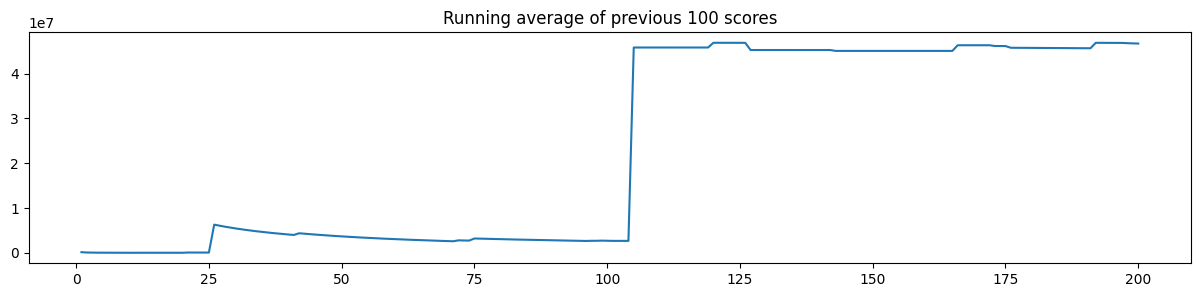

In [17]:
import gym
import numpy as np

if __name__ == '__main__':
    env = StockTradingEnv(df)
    N = 20
    batch_size = 5
    n_epochs = 8
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)
    n_games = 200 # try to increase to get better results

    figure_file = 'sinewave.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_

        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])

        if avg_score > best_score and i > 50:
            best_score = avg_score
            agent.save_models()

        print(f"episide: {i}, score: {score}, avg score: {avg_score}, time_steps: {n_steps}, learning steps: {learn_iters}")

    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)


### Load Model

In [18]:
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo_sine"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax(dim=-1)
  )
)

### Get Results

In [19]:
open_probs = []
hold_probs = []
close_probs = []
actions = []
is_open = 0
num_trades = 0
held_for = 0
num_trades_perc = 0
for step in range(5, len(df)): # 5 periods we included in sequences
    close_item = df.loc[step, "Close_Rt"].item()
    close_rt_item = df.loc[step, "Close_Rt"].item()
    close_T1_item = df.loc[step - 1, "Close_Rt"].item()
    close_T2_item = df.loc[step - 2, "Close_Rt"].item()
    close_T3_item = df.loc[step - 3, "Close_Rt"].item()
    close_T4_item = df.loc[step - 4, "Close_Rt"].item()
    state = np.array([close_item, close_rt_item, close_T1_item, close_T2_item, close_T3_item, close_T4_item,
                      is_open, num_trades_perc])
    state = T.tensor(state).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()

    print(probs)

    if action == 0:
        is_open = 1
        num_trades += 1
        num_trades_perc = num_trades / len(df)
    if action == 1 and is_open:
        held_for += 1
    if action == 2:
        is_open = 0
        held_for = 0

    open_probs.append(probs[0])
    hold_probs.append(probs[1])
    close_probs.append(probs[2])
print(len(open_probs))

[0.13904065 0.85799927 0.00296008]
[0.15697451 0.8392716  0.00375393]
[0.17512688 0.820249   0.00462413]
[0.19135046 0.80315185 0.0054977 ]
[0.20852828 0.7850613  0.00641033]
[0.22696508 0.7656779  0.00735704]
[0.24583554 0.7458065  0.00835794]
[0.26495746 0.72565967 0.00938289]
[0.28411177 0.7054664  0.01042187]
[0.30386627 0.6846893  0.01144444]
[0.32230058 0.6652372  0.01246224]
[0.34090567 0.64556676 0.0135276 ]
[0.36018273 0.62527674 0.0145406 ]
[0.38029858 0.6042266  0.01547489]
[0.40065908 0.5829196  0.01642137]
[0.42096487 0.561797   0.01723816]
[0.44128835 0.5407569  0.01795477]
[0.461296   0.52003294 0.01867105]
[0.4819245  0.49874863 0.01932686]
[0.50422615 0.4759289  0.01984497]
[0.5272593  0.4524135  0.02032719]
[0.5508882  0.42831722 0.0207946 ]
[0.5748567  0.4039688  0.02117448]
[0.5991415  0.37931404 0.02154441]
[0.62302196 0.3552715  0.0217066 ]
[0.64632964 0.33213067 0.02153968]
[0.6707718  0.30808783 0.02114038]
[0.6997864  0.28005797 0.02015564]
[0.7307714  0.250340

In [20]:
df_new = df.copy()
df_new = df_new.iloc[5:, :]
df_new["Opens"] = open_probs
df_new["Holds"] = hold_probs
df_new["Closes"] = close_probs
df_new.head()

,Close,Close_Rt,Opens,Holds,Closes
5,0.782324,0.057601,0.139041,0.857999,0.002960
6,0.822111,0.050858,0.156975,0.839272,0.003754
7,0.858681,0.044482,0.175127,0.820249,0.004624
8,0.891666,0.038414,0.191350,0.803152,0.005498
9,0.920738,0.032604,0.208528,0.785061,0.006410


### Show Results

<Axes: >

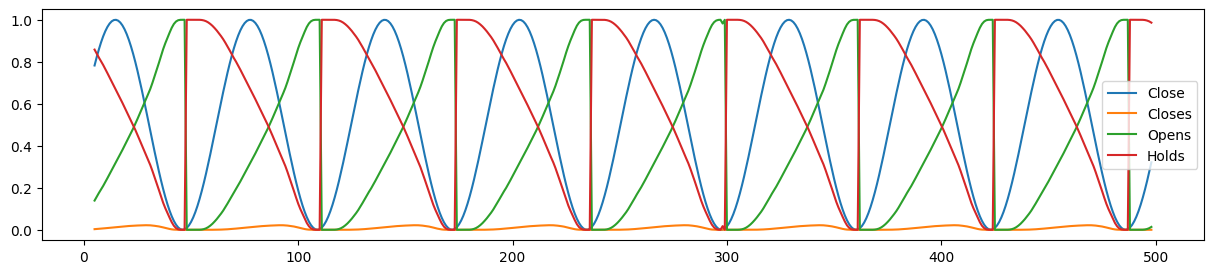

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
df_new[["Close", "Closes", "Opens", "Holds"]].plot()

While the agent performs poorly, it is necessary to retrain it over a larger number of iterations